In [1]:
import h5py
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import yaml

# plt.rcParams["figure.dpi"] = 200
# reduced for quick viewing
plt.rcParams["figure.dpi"] = 400
plt.rcParams["text.usetex"] = False
# disabled due to missing font in texlive on the Nikhef clusters
# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.constrained_layout.use"] = True

In [2]:
hdf_dir = "/data/atlas/users/slin/myHepattn/hepattn/src/hepattn/experiments/trackml/logs/TRK-v0-full_20250906-T205842/ckpts/epoch=029-val_loss=50.09092_test_eval.h5"

In [3]:
f = h5py.File(hdf_dir, "r")
for key in f.keys():
    print("Key: %s  \tType: %s" % (key, type(f[key])))

Key: 29800  	Type: <class 'h5py._hl.group.Group'>
Key: 29801  	Type: <class 'h5py._hl.group.Group'>
Key: 29802  	Type: <class 'h5py._hl.group.Group'>
Key: 29803  	Type: <class 'h5py._hl.group.Group'>
Key: 29804  	Type: <class 'h5py._hl.group.Group'>
Key: 29805  	Type: <class 'h5py._hl.group.Group'>
Key: 29806  	Type: <class 'h5py._hl.group.Group'>
Key: 29807  	Type: <class 'h5py._hl.group.Group'>
Key: 29808  	Type: <class 'h5py._hl.group.Group'>
Key: 29809  	Type: <class 'h5py._hl.group.Group'>
Key: 29810  	Type: <class 'h5py._hl.group.Group'>
Key: 29811  	Type: <class 'h5py._hl.group.Group'>
Key: 29812  	Type: <class 'h5py._hl.group.Group'>
Key: 29813  	Type: <class 'h5py._hl.group.Group'>
Key: 29814  	Type: <class 'h5py._hl.group.Group'>
Key: 29815  	Type: <class 'h5py._hl.group.Group'>
Key: 29816  	Type: <class 'h5py._hl.group.Group'>
Key: 29817  	Type: <class 'h5py._hl.group.Group'>
Key: 29818  	Type: <class 'h5py._hl.group.Group'>
Key: 29819  	Type: <class 'h5py._hl.group.Group'>


In [4]:
group_key = list(f.keys())[2]
k = list(f[group_key])
for j in k:
    print(j)
    print("\t", f[group_key][j].keys())

inputs
	 <KeysViewHDF5 ['hit_charge_frac', 'hit_eta', 'hit_geta', 'hit_gphi', 'hit_leta', 'hit_lphi', 'hit_lx', 'hit_ly', 'hit_lz', 'hit_phi', 'hit_r', 'hit_s', 'hit_u', 'hit_v', 'hit_valid', 'hit_x', 'hit_y', 'hit_z']>
outputs
	 <KeysViewHDF5 ['final']>
preds
	 <KeysViewHDF5 ['final']>
targets
	 <KeysViewHDF5 ['hit_on_valid_particle', 'hit_valid', 'particle_eta', 'particle_hit_valid', 'particle_phi', 'particle_pt', 'particle_px', 'particle_py', 'particle_pz', 'particle_valid', 'particle_vz', 'sample_id']>


# Evaluation file structure

## `inputs` group

In [5]:
print("\ninputs")
print("\t", list(f[group_key]["inputs"]))

print("\n============================")

print("\ninputs/hit_eta")
print("\t", list(f[group_key]["inputs"]["hit_eta"]))


inputs
	 ['hit_charge_frac', 'hit_eta', 'hit_geta', 'hit_gphi', 'hit_leta', 'hit_lphi', 'hit_lx', 'hit_ly', 'hit_lz', 'hit_phi', 'hit_r', 'hit_s', 'hit_u', 'hit_v', 'hit_valid', 'hit_x', 'hit_y', 'hit_z']


inputs/hit_eta
	 [array([-3.783, -3.86 , -3.941, ...,  4.01 ,  2.87 ,  2.908],
      shape=(11368,), dtype=float16)]


## `outputs` group

In [6]:
print("\noutputs/final/")
print("\t", list(f[group_key]["outputs"]["final"]))

print("\n============================")

print("\noutputs/final/track_hit_valid/")
print("\t", list(f[group_key]["outputs"]["final"]["track_hit_valid"]))
print("\noutputs/final/track_hit_valid/track_hit_logit")
print("\t", list(f[group_key]["outputs"]["final"]["track_hit_valid"]["track_hit_logit"]))

if "track_regr" in list(f[group_key]["outputs"]["final"]):
    print("\n============================")

    print("\noutputs/final/track_regr/")
    print("\t", list(f[group_key]["outputs"]["final"]["track_regr"]))
    print("\noutputs/final/track_regr/track_regr")
    print("\t", list(f[group_key]["outputs"]["final"]["track_regr"]["track_regr"]))

print("\n============================")

print("\noutputs/final/track_valid/")
print("\t", list(f[group_key]["outputs"]["final"]["track_valid"]))
print("\noutputs/final/track_hit_valid/track_hit_logit")
print("\t", list(f[group_key]["outputs"]["final"]["track_valid"]["track_logit"]))


outputs/final/
	 ['track_hit_valid', 'track_regr', 'track_valid']


outputs/final/track_hit_valid/
	 ['track_hit_logit']

outputs/final/track_hit_valid/track_hit_logit
	 [array([[ -28.62 ,  -33.75 ,  -35.25 , ...,  -40.75 ,  -39.   ,  -37.5  ],
       [-145.   , -191.   , -191.   , ..., -189.   , -189.   , -172.   ],
       [ -97.5  , -127.5  , -142.   , ..., -143.   , -183.   , -170.   ],
       ...,
       [ -23.75 ,  -36.75 ,  -31.88 , ...,  -27.5  ,  -24.12 ,  -27.12 ],
       [ -47.25 ,  -70.   ,  -55.   , ...,  -48.25 ,  -49.5  ,  -43.25 ],
       [  -8.5  ,  -11.06 ,  -12.875, ...,  -17.5  ,  -17.5  ,  -16.12 ]],
      shape=(2200, 11368), dtype=float16)]


outputs/final/track_regr/
	 ['track_regr']

outputs/final/track_regr/track_regr
	 [array([[ 1.578e+00,  3.113e-02, -7.500e-01, -3.275e+01],
       [ 6.289e-01,  1.297e+00,  1.725e+01, -4.425e+01],
       [ 1.180e+00,  8.828e-01,  5.625e+00, -3.425e+01],
       ...,
       [-1.523e+00,  2.832e-01, -2.891e-01, -3.300e+01],
   

## `preds` group

In [7]:
print("\npreds/final/")
print("\t", list(f[group_key]["preds"]["final"]))
print("\n============================")

print("\npreds/final/track_hit_valid/")
print("\t", list(f[group_key]["preds"]["final"]["track_hit_valid"]))
print("\npreds/final/track_hit_valid/track_hit_valid")
print("\t", list(f[group_key]["preds"]["final"]["track_hit_valid"]["track_hit_valid"]))

if "track_regr" in list(f[group_key]["preds"]["final"]):
    print("\n============================")

    print("\npreds/final/track_regr/")
    print("\t", list(f[group_key]["preds"]["final"]["track_regr"]))
    print("\npreds/final/track_regr/track_px")
    print("\t", list(f[group_key]["preds"]["final"]["track_regr"]["track_px"]))
    print("\npreds/final/track_regr/track_py")
    print("\t", list(f[group_key]["preds"]["final"]["track_regr"]["track_py"]))
    print("\npreds/final/track_regr/track_pz")
    print("\t", list(f[group_key]["preds"]["final"]["track_regr"]["track_pz"]))
    print("\npreds/final/track_regr/track_vx")
    print("\t", list(f[group_key]["preds"]["final"]["track_regr"]["track_vz"]))

print("\n============================")

print("\npreds/final/track_valid/")
print("\t", list(f[group_key]["preds"]["final"]["track_valid"]))
print("\npreds/final/track_valid/track_valid")
print("\t", list(f[group_key]["preds"]["final"]["track_valid"]["track_valid"]))


preds/final/
	 ['track_hit_valid', 'track_regr', 'track_valid']


preds/final/track_hit_valid/
	 ['track_hit_valid']

preds/final/track_hit_valid/track_hit_valid
	 [array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(2200, 11368))]


preds/final/track_regr/
	 ['track_px', 'track_py', 'track_pz', 'track_vz']

preds/final/track_regr/track_px
	 [array([ 1.578 ,  0.629 ,  1.18  , ..., -1.523 , -1.258 , -0.6055],
      shape=(2200,), dtype=float16)]

preds/final/track_regr/track_py
	 [array([ 0.03113,  1.297  ,  0.883  , ...,  0.2832 ,  0.5117 , -0.715  ],
      shape=(2200,), dtype=float16)]

preds/final/track_regr/track_pz
	 [array([-0.75 , 17.25 ,  5.625, ..., -0.289, -2.328, -5.53 

## `targets` group

In [8]:
print("\ntargets/")
print("\t", list(f[group_key]["targets"]))

print("\n============================")

print("\ntargets/hit_on_valid_particle")
print("\t", list(f[group_key]["targets"]["hit_on_valid_particle"]))
print("\ntargets/hit_valid")
print("\t", list(f[group_key]["targets"]["hit_valid"]))
print("\ntargets/particle_eta")
print("\t", list(f[group_key]["targets"]["particle_eta"]))
print("\ntargets/particle_px")
print("\t", list(f[group_key]["targets"]["particle_pt"]))
print("\ntargets/particle_hit_valid")
print("\t", list(f[group_key]["targets"]["particle_hit_valid"]))
print("\ntargets/particle_valid")
print("\t", list(f[group_key]["targets"]["particle_valid"]))


targets/
	 ['hit_on_valid_particle', 'hit_valid', 'particle_eta', 'particle_hit_valid', 'particle_phi', 'particle_pt', 'particle_px', 'particle_py', 'particle_pz', 'particle_valid', 'particle_vz', 'sample_id']


targets/hit_on_valid_particle
	 [array([ True,  True,  True, ...,  True,  True,  True], shape=(11368,))]

targets/hit_valid
	 [array([ True,  True,  True, ...,  True,  True,  True], shape=(11368,))]

targets/particle_eta
	 [array([-0.47555587,  3.339603  ,  2.2312822 , ...,         nan,
               nan,         nan], shape=(2200,), dtype=float32)]

targets/particle_px
	 [array([2.3445141 , 0.90341383, 1.0691355 , ...,        nan,        nan,
              nan], shape=(2200,), dtype=float32)]

targets/particle_hit_valid
	 [array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False

# Tracking model evaluation

## Plot parameters

In [9]:
training_colours = {
    "600 MeV": "mediumvioletred",
    "750 MeV": "cornflowerblue",
    # "1 GeV": "mediumseagreen",  # |eta| < 2.5
    "0.9 GeV": "mediumseagreen",  # |eta| < 4.0
}

qty_bins = {
    "pt": np.array([0.6, 0.75, 1.0, 1.5, 2, 3, 4, 6, 10]),
    # "eta": np.array([-2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5]),
    "eta": np.array([-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]),
    "phi": np.array([-3.14, -2.36, -1.57, -0.79, 0, 0.79, 1.57, 2.36, 3.14]),
    "vz": np.array([-100, -50, -20, -10, 0, 10, 20, 50, 100]),
}

qty_symbols = {"pt": "p_\\mathrm{T}", "eta": "\\eta", "phi": "\\phi", "vz": "v_z"}
qty_units = {"pt": "[GeV]", "eta": "", "phi": "", "vz": "[mm]"}
out_dir = "plots"

## Retrieve tracking model configuration

In [10]:
with open("/data/atlas/users/slin/myHepattn/hepattn/src/hepattn/experiments/trackml/configs/tracking.yaml", "r") as f:
    fconfig= yaml.safe_load(f)

tracking_params = ["particle_min_pt", "particle_max_abs_eta"]

print("name: "+fconfig["name"])
for i in tracking_params:
    print("> "+i+"\t: ", fconfig["data"][i])
    
tracking_configs = {
    "0.9 GeV": fconfig
}

tracking_fnames = {
    "0.9 GeV": "/data/atlas/users/slin/myHepattn/hepattn/src/hepattn/experiments/trackml/logs/TRK-v0-full_20250906-T205842/ckpts/epoch=029-val_loss=50.09092_test_eval.h5"
}
tracking_inputs = ["hits_"+tracking_configs["0.9 GeV"]["data"]["inputs"]["hit"][i] for i in range(len(tracking_configs["0.9 GeV"]["data"]["inputs"]["hit"]))]
particle_targets = ["particle_"+i for i in list(tracking_configs["0.9 GeV"]["data"]["targets"]["particle"])]
print("> inputs: ", tracking_inputs)
print("> particle targets: ", particle_targets)

name: TRK-v0-full
> particle_min_pt	:  0.9
> particle_max_abs_eta	:  4.0
> inputs:  ['hits_x', 'hits_y', 'hits_z', 'hits_r', 'hits_s', 'hits_eta', 'hits_phi', 'hits_u', 'hits_v', 'hits_charge_frac', 'hits_leta', 'hits_lphi', 'hits_lx', 'hits_ly', 'hits_lz', 'hits_geta', 'hits_gphi']
> particle targets:  ['particle_pt', 'particle_eta', 'particle_phi', 'particle_px', 'particle_py', 'particle_pz', 'particle_vz']


## Load evaluation file

In [11]:
import importlib
import plot_utils
import track_evaluate
importlib.reload(plot_utils)
importlib.reload(track_evaluate)
from plot_utils import binned, profile_plot
from track_evaluate import load_events

In [12]:
%%time
tracking_results = {}
num_events=None
for name, fname in tracking_fnames.items():
    eta_cut = tracking_configs[name]["data"]["particle_max_abs_eta"]
    pt_cut = tracking_configs[name]["data"]["particle_min_pt"]
    tracking_results[name] = load_events(fname, eta_cut=eta_cut, pt_cut=pt_cut, particle_targets=particle_targets)

/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29800


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29801


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29802


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29803


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29804
loaded event #29805


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29806


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29807
loaded event #29808


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29809
loaded event #29810


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29811
loaded event #29812


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29813
loaded event #29814


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29815
loaded event #29816


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29817
loaded event #29818


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29819
loaded event #29820


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29821
loaded event #29822


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29823
loaded event #29824


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29825


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29826
loaded event #29827


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29828
loaded event #29829


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29830
loaded event #29831


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29832
loaded event #29833


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29834
loaded event #29835


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29836
loaded event #29837


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29838
loaded event #29839


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29840
loaded event #29841


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29842
loaded event #29843


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29844
loaded event #29845


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29846
loaded event #29847


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29848
loaded event #29849


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29850
loaded event #29851


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29852
loaded event #29853


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29854
loaded event #29855


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29856
loaded event #29857


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29858
loaded event #29859


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29860
loaded event #29861


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29862
loaded event #29863


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29864
loaded event #29865


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29866


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29867
loaded event #29868


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29869
loaded event #29870


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29871
loaded event #29872


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29873
loaded event #29874


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29875
loaded event #29876


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29877
loaded event #29878


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29879
loaded event #29880


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29881
loaded event #29882


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29883
loaded event #29884


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29885
loaded event #29886


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29887
loaded event #29888


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29889
loaded event #29890


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29891
loaded event #29892


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29893
loaded event #29894


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29895
loaded event #29896


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29897
loaded event #29898


/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


loaded event #29899
CPU times: user 16.8 s, sys: 911 ms, total: 17.7 s
Wall time: 17.7 s


## Plot efficiency and fake rate 

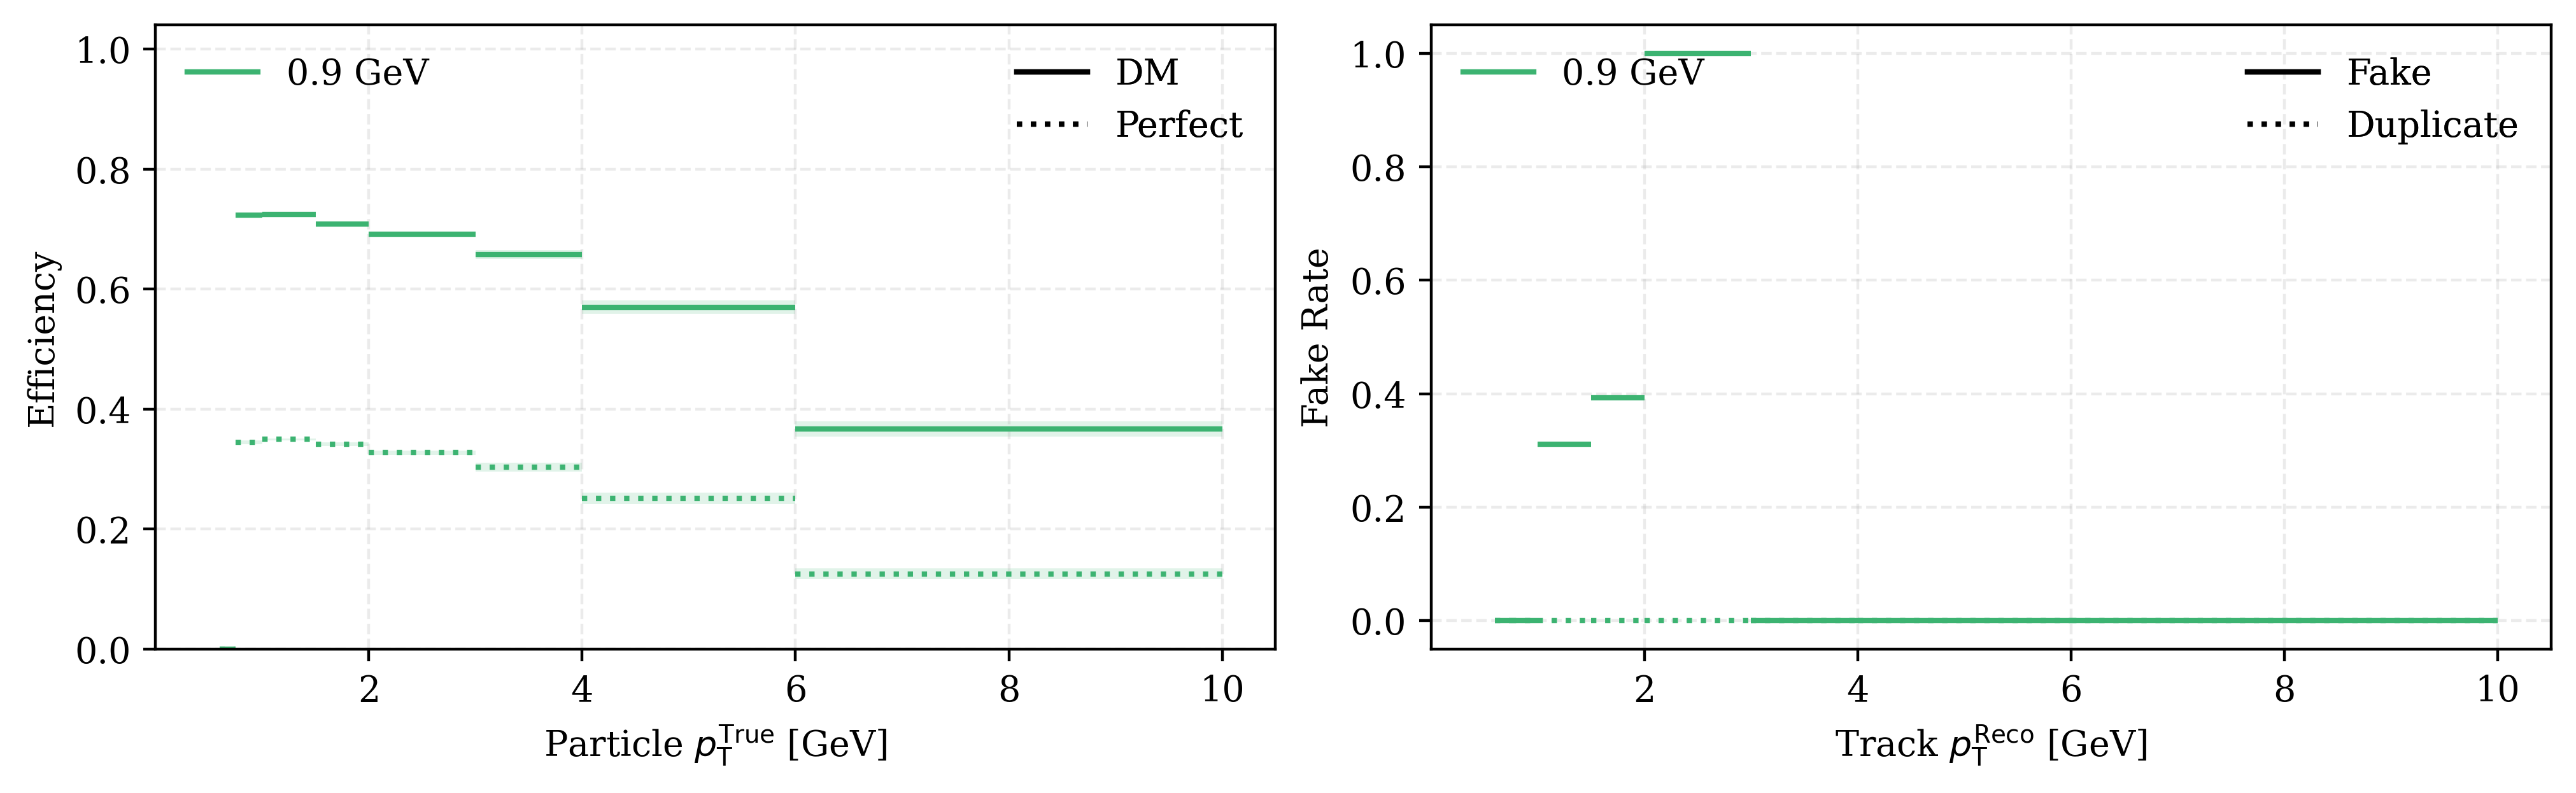

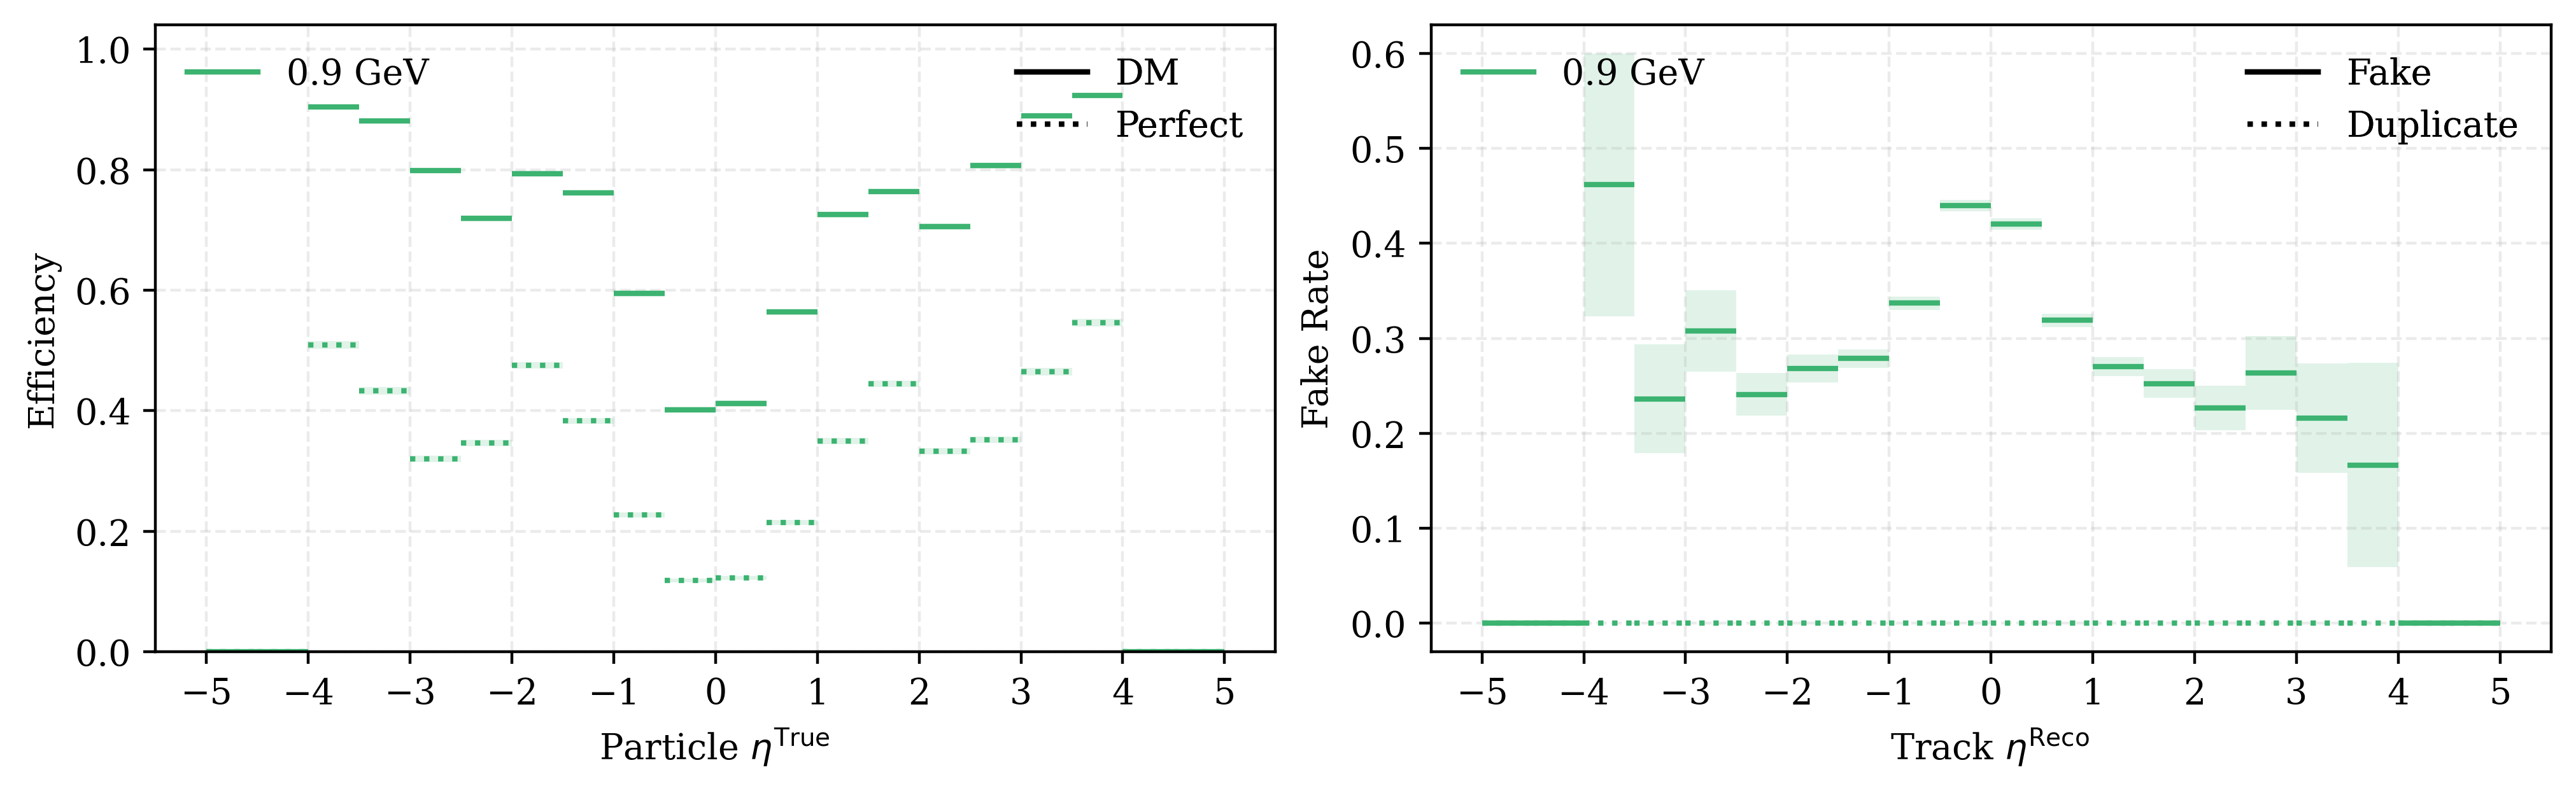

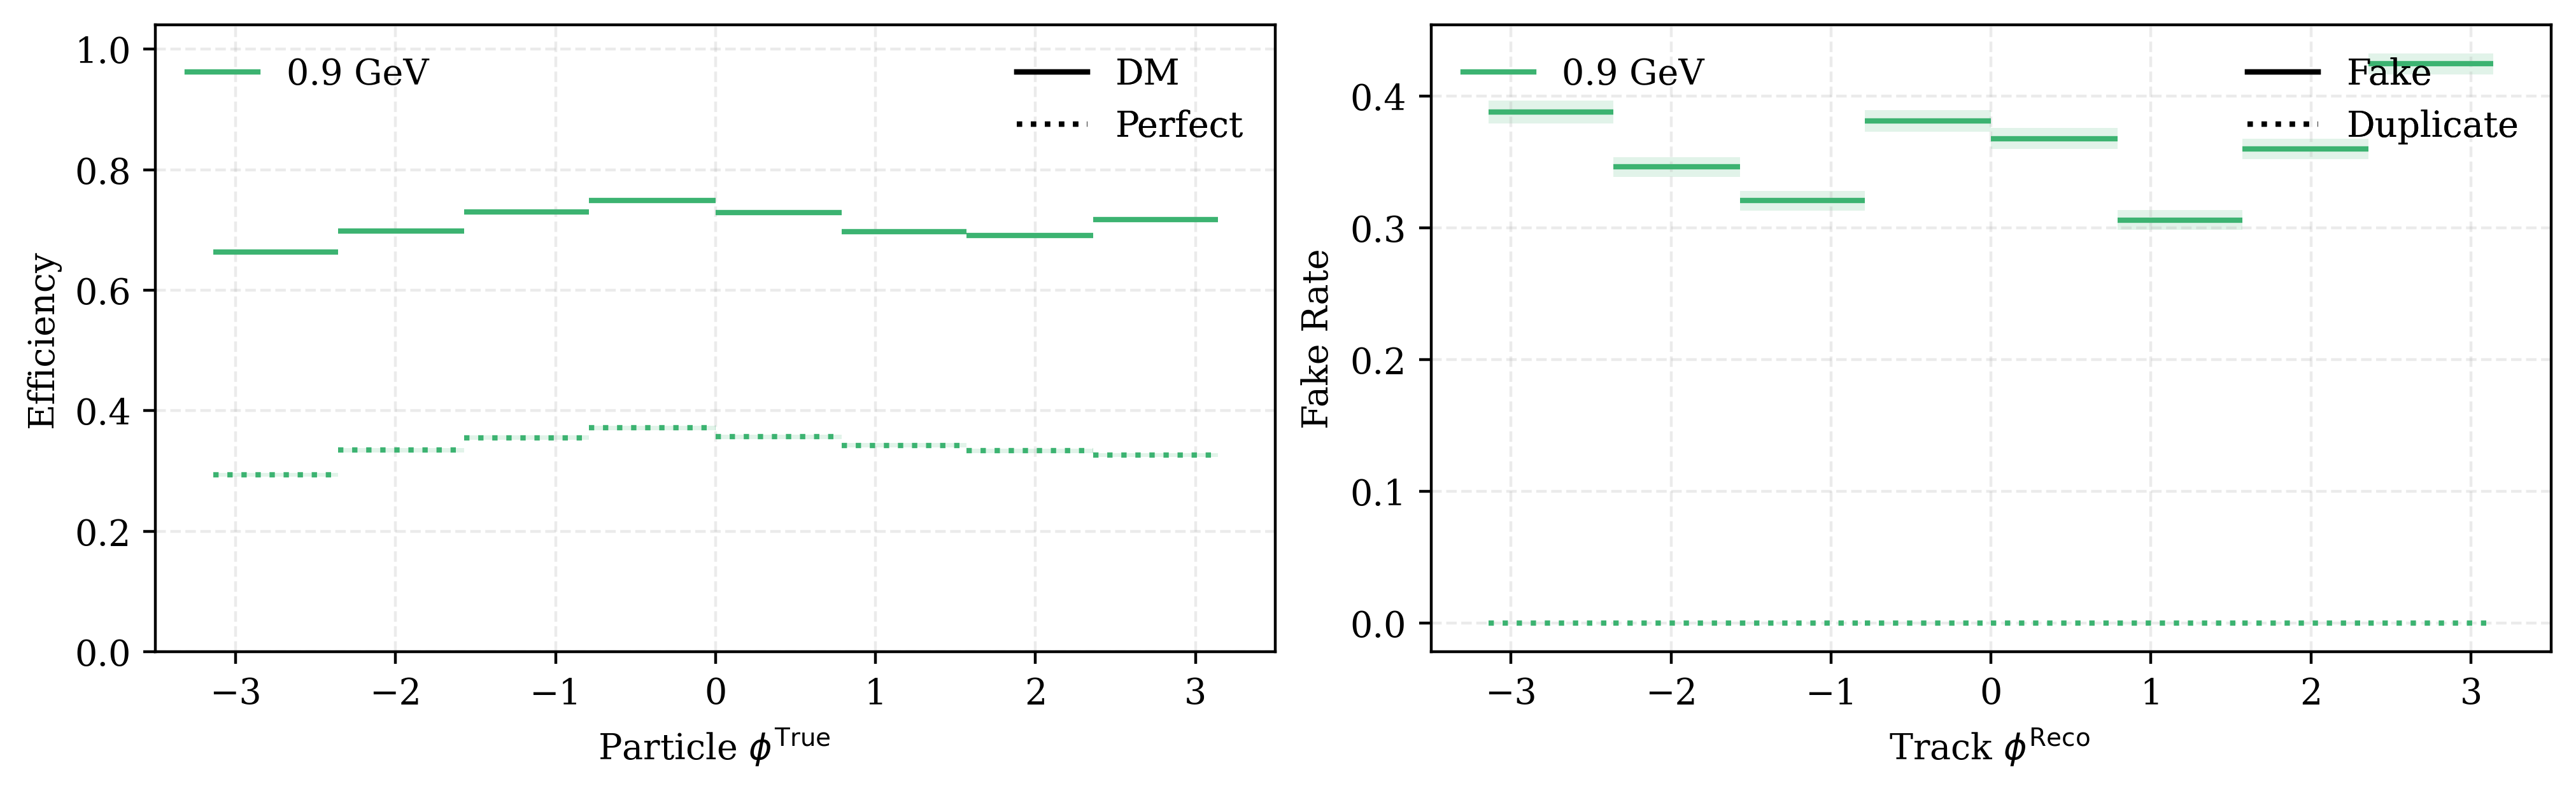

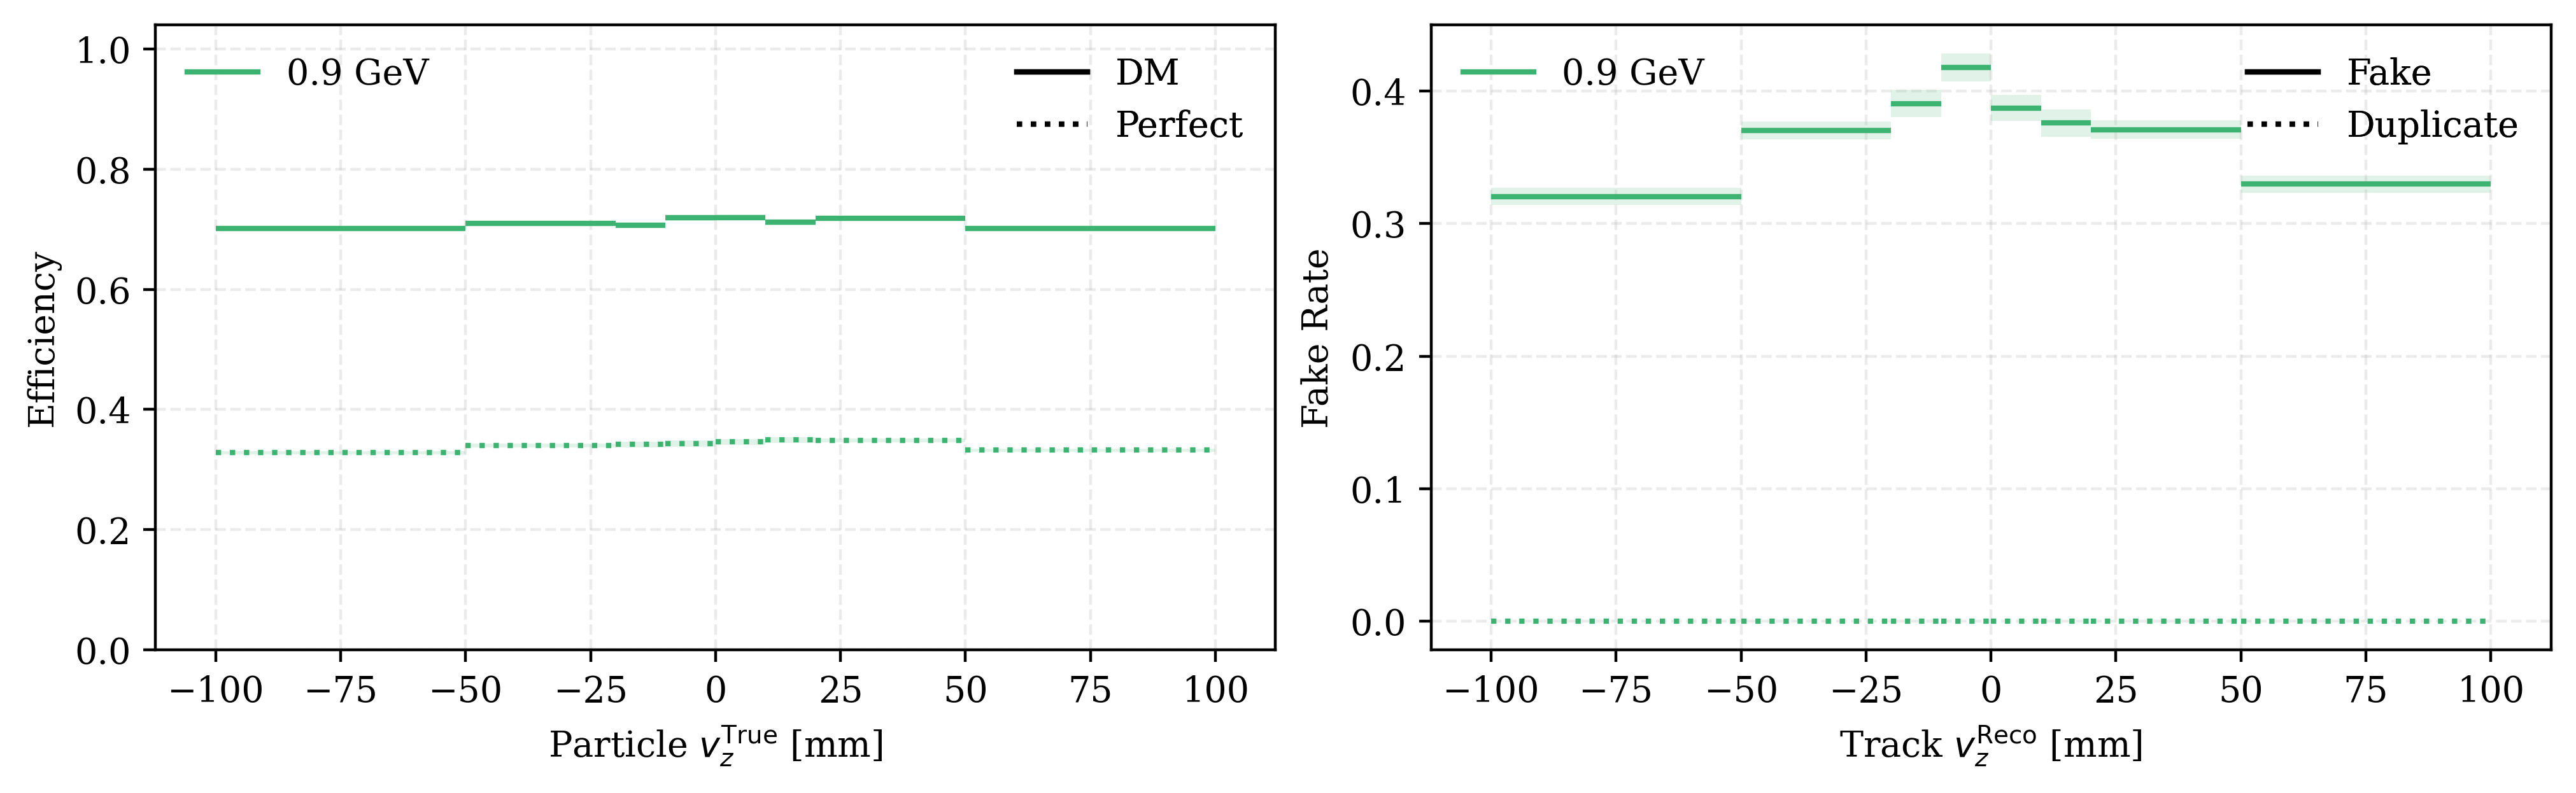

In [13]:
for qty in ["pt", "eta", "phi", "vz"] : 
    fig, ax = plt.subplots(ncols=2, figsize=(10,3), constrained_layout=True)
    for name, (tracks, parts) in tracking_results.items():
        """Efficiency plots"""
        reconstructable = parts["reconstructable"]
        # double majority
        bin_count, bin_error = binned(tracks["eff_dm"][reconstructable], parts["particle_"+qty][reconstructable], qty_bins[qty], underflow=True, overflow=True, binomial=False)
        profile_plot(bin_count, bin_error, qty_bins[qty], axes=ax[0], color=training_colours[name], ls="solid")
        # perfect
        bin_count, bin_error = binned(tracks["eff_perfect"][reconstructable], parts["particle_"+qty][reconstructable], qty_bins[qty], underflow=True, overflow=True, binomial=False)
        profile_plot(bin_count, bin_error, qty_bins[qty], axes=ax[0], color=training_colours[name], ls="dotted")
        """Fake rate plots"""
        reconstructable = tracks["reconstructable"]
        # fake rate
        fakes = (~tracks["eff_dm"]) & (~tracks["duplicate"])
        bin_count, bin_error = binned(fakes[reconstructable], tracks["track_"+qty][reconstructable], qty_bins[qty], underflow=True, overflow=True, binomial=False)
        profile_plot(bin_count, bin_error, qty_bins[qty], axes=ax[1], color=training_colours[name], ls="solid")
        # duplicate
        bin_count, bin_error = binned(tracks["duplicate"][reconstructable], tracks["track_"+qty][reconstructable], qty_bins[qty], underflow=True, overflow=True, binomial=False)
        profile_plot(bin_count, bin_error, qty_bins[qty], axes=ax[1], color=training_colours[name], ls="dotted")
    
    # custom legends
    legend_elements_0 = [Line2D([0], [0], color=training_colours[name], label=training) for training in tracking_results]
    #legend_elements_1 = [Line2D([0], [0], color=training_colours[training], label=training) for training in tracking_results]
    leg1_0 = ax[0].legend(handles=legend_elements_0, frameon=False, loc="upper left")
    ax[0].add_artist(leg1_0)
    leg1_1 = ax[1].legend(handles=legend_elements_0, frameon=False, loc="upper left")
    ax[1].add_artist(leg1_1)
    legend_elements_eff = [Line2D([0], [0], color="black", label="DM"), Line2D([0], [0], color="black", ls="dotted", label="Perfect")]
    leg2_0 = ax[0].legend(handles=legend_elements_eff, frameon=False, loc="upper right")
    ax[0].add_artist(leg2_0)
    legend_elements_fake = [Line2D([0], [0], color="black", label="Fake"), Line2D([0], [0], color="black", ls="dotted", label="Duplicate")]
    leg2_1 = ax[1].legend(handles=legend_elements_fake, frameon=False, loc="upper right")
    ax[1].add_artist(leg2_1)

    # axis range and label
    ax[0].set_ylim(0, 1.04)
    for i in range(2):
        ax[i].set_xlabel(rf"Particle ${qty_symbols[qty]}^\mathrm{{True}}$ {qty_units[qty]}")
        ax[i].grid(zorder=0, alpha=0.25, linestyle="--")
        if qty == "pt":
            ax[i].set_xlim([0, 10.5])
            ax[i].set_xticks(np.arange(start=2, stop=11, step=2))
            #ax[1].set_ylim(0.0, 0.03)
        if qty == "eta":
            ax[i].set_xlim([-5.5, 5.5])
            ax[i].set_xticks(np.arange(start=-5, stop=5.5, step=1))
            
        if qty == "phi":
            ax[i].set_xlim([-3.5, 3.5])
            ax[i].set_xticks(np.arange(start=-3, stop=3.5, step=1))
            #ax[1].set_ylim(0.0, 0.02)
        if qty == "vz":
            ax[i].set_xlim([-112, 112])
            ax[i].set_xticks(np.arange(start=-100, stop=110, step=25))
            #ax[1].set_ylim(0.0, 0.02)
            
    ax[0].set_xlabel(rf"Particle ${qty_symbols[qty]}^\mathrm{{True}}$ {qty_units[qty]}")
    ax[0].set_ylabel("Efficiency")

    ax[1].set_xlabel(rf"Track ${qty_symbols[qty]}^\mathrm{{Reco}}$ {qty_units[qty]}")
    ax[1].set_ylabel("Fake Rate")

    fig.savefig(out_dir +f"/{qty}_eff_fr.pdf")
    plt.show()

## Regression residual plots

/data/atlas/users/slin/miniforge3/envs/myEnv/lib/python3.11/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


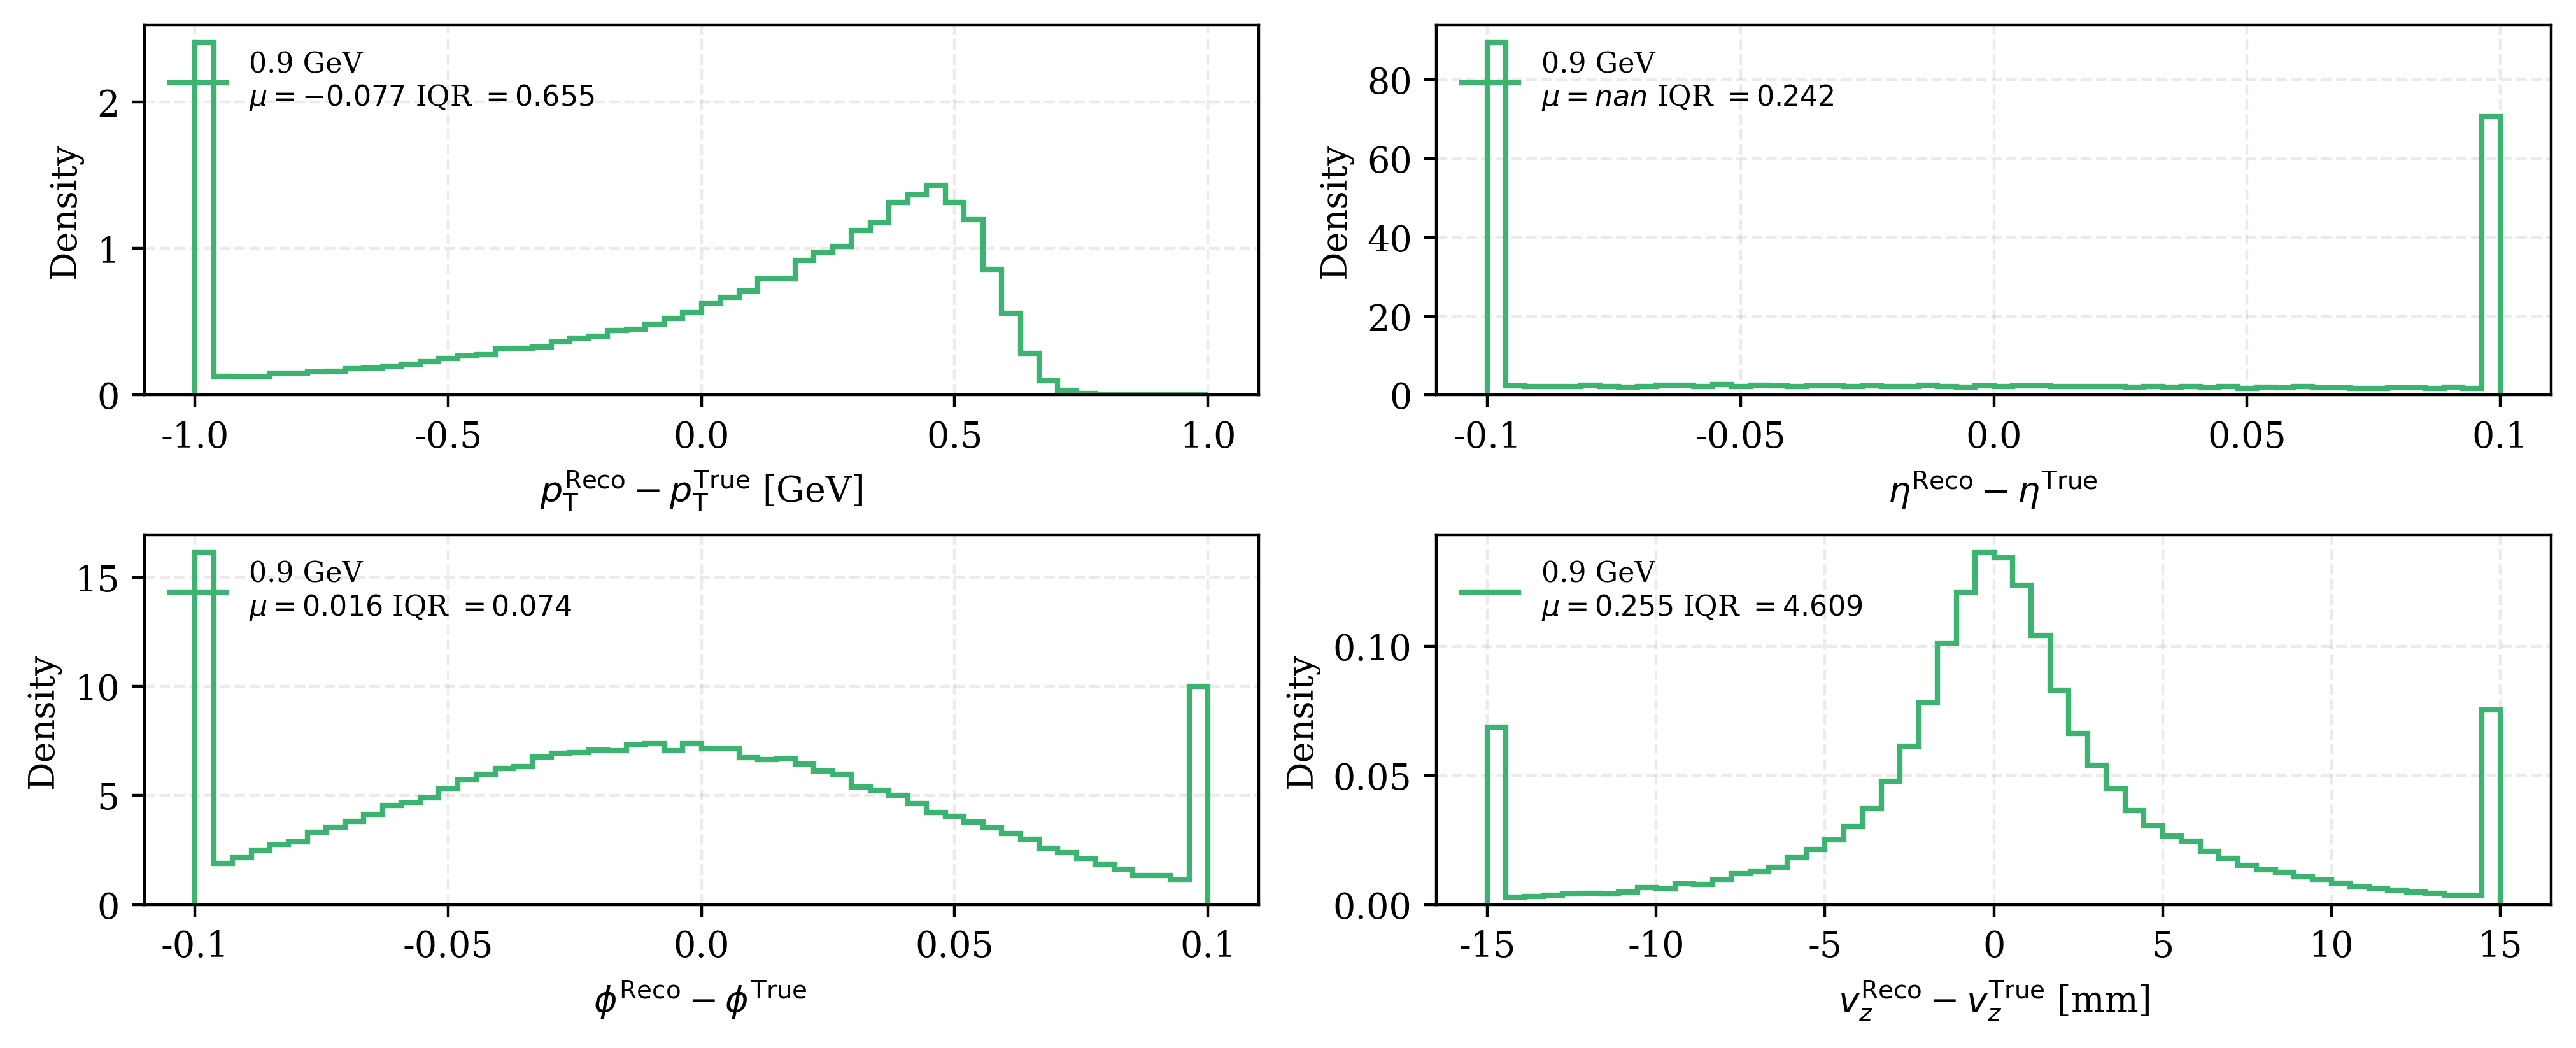

In [14]:
nbins = 55
qty_res_bins = {"pt": np.linspace(-1, 1, nbins), "eta": np.linspace(-0.1, 0.1, nbins), "phi": np.linspace(-0.1, 0.1, nbins), "vz": np.linspace(-15, 15, nbins)}
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig.set_size_inches(10, 4)
ax = ax.flatten()

for i, qty in enumerate(["pt", "eta", "phi", "vz"]) :
    labels = []
    colours = []
    for name, (tracks, parts) in tracking_results.items():
        bins = qty_res_bins[qty]
        bin_centres = (qty_res_bins[qty][:-1] + qty_res_bins[qty][1:]) / 2
        bin_widths = (qty_res_bins[qty][1:] - qty_res_bins[qty][:-1]) / 2

        # track physicsal quantity regression predicted value
        tracks_qty = tracks["track_"+qty][tracks["eff_dm"]]
        # particle physical quantity true value
        parts_qty = parts["particle_"+qty][tracks["eff_dm"]]
        res = tracks_qty - parts_qty
        res_mean = res.mean()
        res_std = res.std()
        res_q25 = res.quantile(0.25)
        res_q75 = res.quantile(0.75)
        res_iqr = res_q75 - res_q25
        res = np.clip(res, bins[0], bins[-1])

        colour = training_colours[name]
        label = name + "\n" + rf"$\mu = {res_mean:.3f}$" + " " + rf"IQR $ = {res_iqr:.3f}$"
        labels.append(label)
        colours.append(colour)

        ax[i].grid(zorder=0, alpha=0.25, linestyle="--")
        ax[i].hist(res, bins=bins, histtype="step", color=training_colours[name], density=True, label=label, lw=1.5)

        ax[i].set_xlabel(rf"${qty_symbols[qty]}^\mathrm{{Reco}} - {qty_symbols[qty]}^\mathrm{{True}}$ {qty_units[qty]}")
        ax[i].set_ylabel("Density")

        ticks = None
        if qty in {"eta", "phi"}:
            ticks = np.arange(-0.1, 0.11, 0.05).round(2)
        if qty == "pt":
            ticks = np.arange(-1, 1.1, 0.5).round(2)
        if qty == "vz":
            ticks = np.arange(-15, 16, 5).round(2)
            
        ax[i].set_xticks(ticks)
        ax[i].set_xticklabels(ticks)

    legend_elements = [Line2D([0], [0], color=colours[j], label=labels[j]) for j in range(len(labels))]
    ax[i].legend(handles=legend_elements, frameon=False, loc="upper left", fontsize=8)
    
fig.savefig(out_dir + "/regr_residuals.pdf")
fig.show()


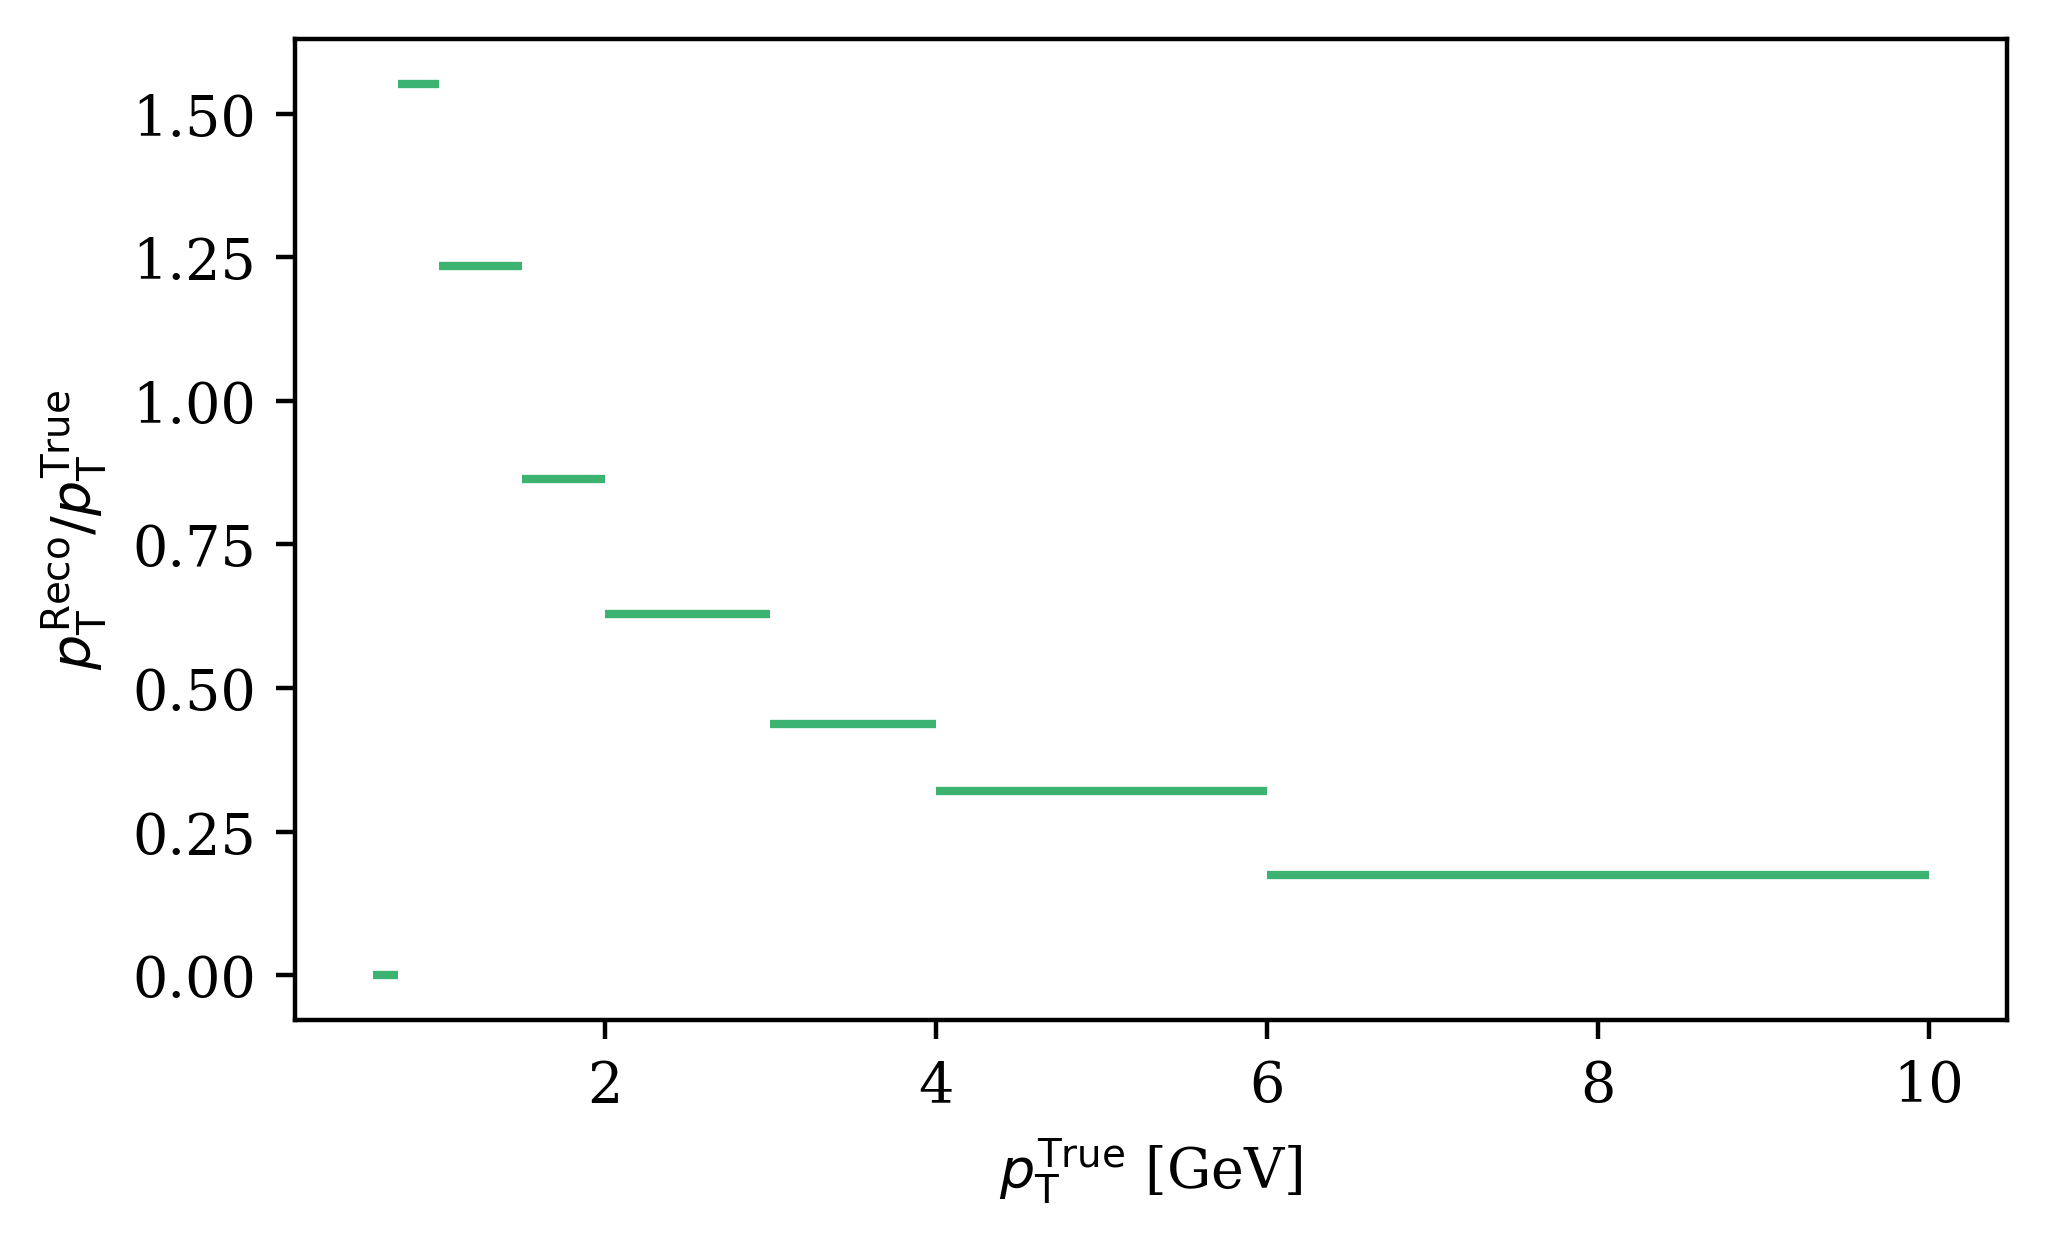

In [15]:
# pt residual vs eta
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(5, 3)

qty = "pt"
vs_qty = "pt"
nbins = 55

for name, (tracks, parts) in tracking_results.items():
    bins = qty_bins[vs_qty]
    bin_centres = (qty_bins[qty][:-1] + qty_bins[qty][1:]) / 2
    bin_widths = (qty_bins[qty][1:] - qty_bins[qty][:-1]) / 2
    tracks_eff_qty = tracks["track_"+vs_qty][tracks["eff_dm"]]
    parts_eff_qty = parts["particle_"+vs_qty][tracks["eff_dm"]]
    # ys = (tracks_eff[f"matched_{qty}"] - tracks_eff[qty]).abs()
    ys = tracks_eff_qty / parts_eff_qty
    ys, ys_err = binned(ys, parts_eff_qty, bins, underflow=True, overflow=True, binomial=False)
    profile_plot(ys, ys_err, bins, axes=ax, color=training_colours[name], ls="solid")

# ax.set_xlabel(r"Particle $\eta^\mathrm{True}$")
ax.set_xlabel(rf"${qty_symbols[qty]}^\mathrm{{True}}$ {qty_units[qty]}")
# ax.set_xlabel(rf"Particle $p_\mathrm{{T}}^\mathrm{{True}}$ [GeV]")
# ax.set_ylabel(rf"$|p_\mathrm{{T}}^\mathrm{{Reco}} - p_\mathrm{{T}}^\mathrm{{True}}|/ p_\mathrm{{T}}^\mathrm{{True}}$ [GeV]")
ax.set_ylabel(rf"${qty_symbols[qty]}^\mathrm{{Reco}}/{qty_symbols[qty]}^\mathrm{{True}}$")
#fig.savefig(out_dir + "/regr_norm_residuals_vs_pt.pdf")
plt.show()

/tmp/ipykernel_1329526/1169679580.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[0].errorbar(b, ys, yerr=None, xerr=b_err, color=colour, fmt=".", label=label, marker="s", markersize=2.0)
/tmp/ipykernel_1329526/1169679580.py:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[0].errorbar(b, ys, yerr=ys_err, xerr=None, color=colour, fmt=".", marker="none", capsize=5.0, markeredgewidth=1.0)
/tmp/ipykernel_1329526/1169679580.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[1].errorbar(b, ys, yerr=None, xerr=b_err, color=colour, fmt=".", label=label, marker="s", markersize=2.0)
/tmp/ipykernel_1329526/1169679580.py:35: UserWarning: mark

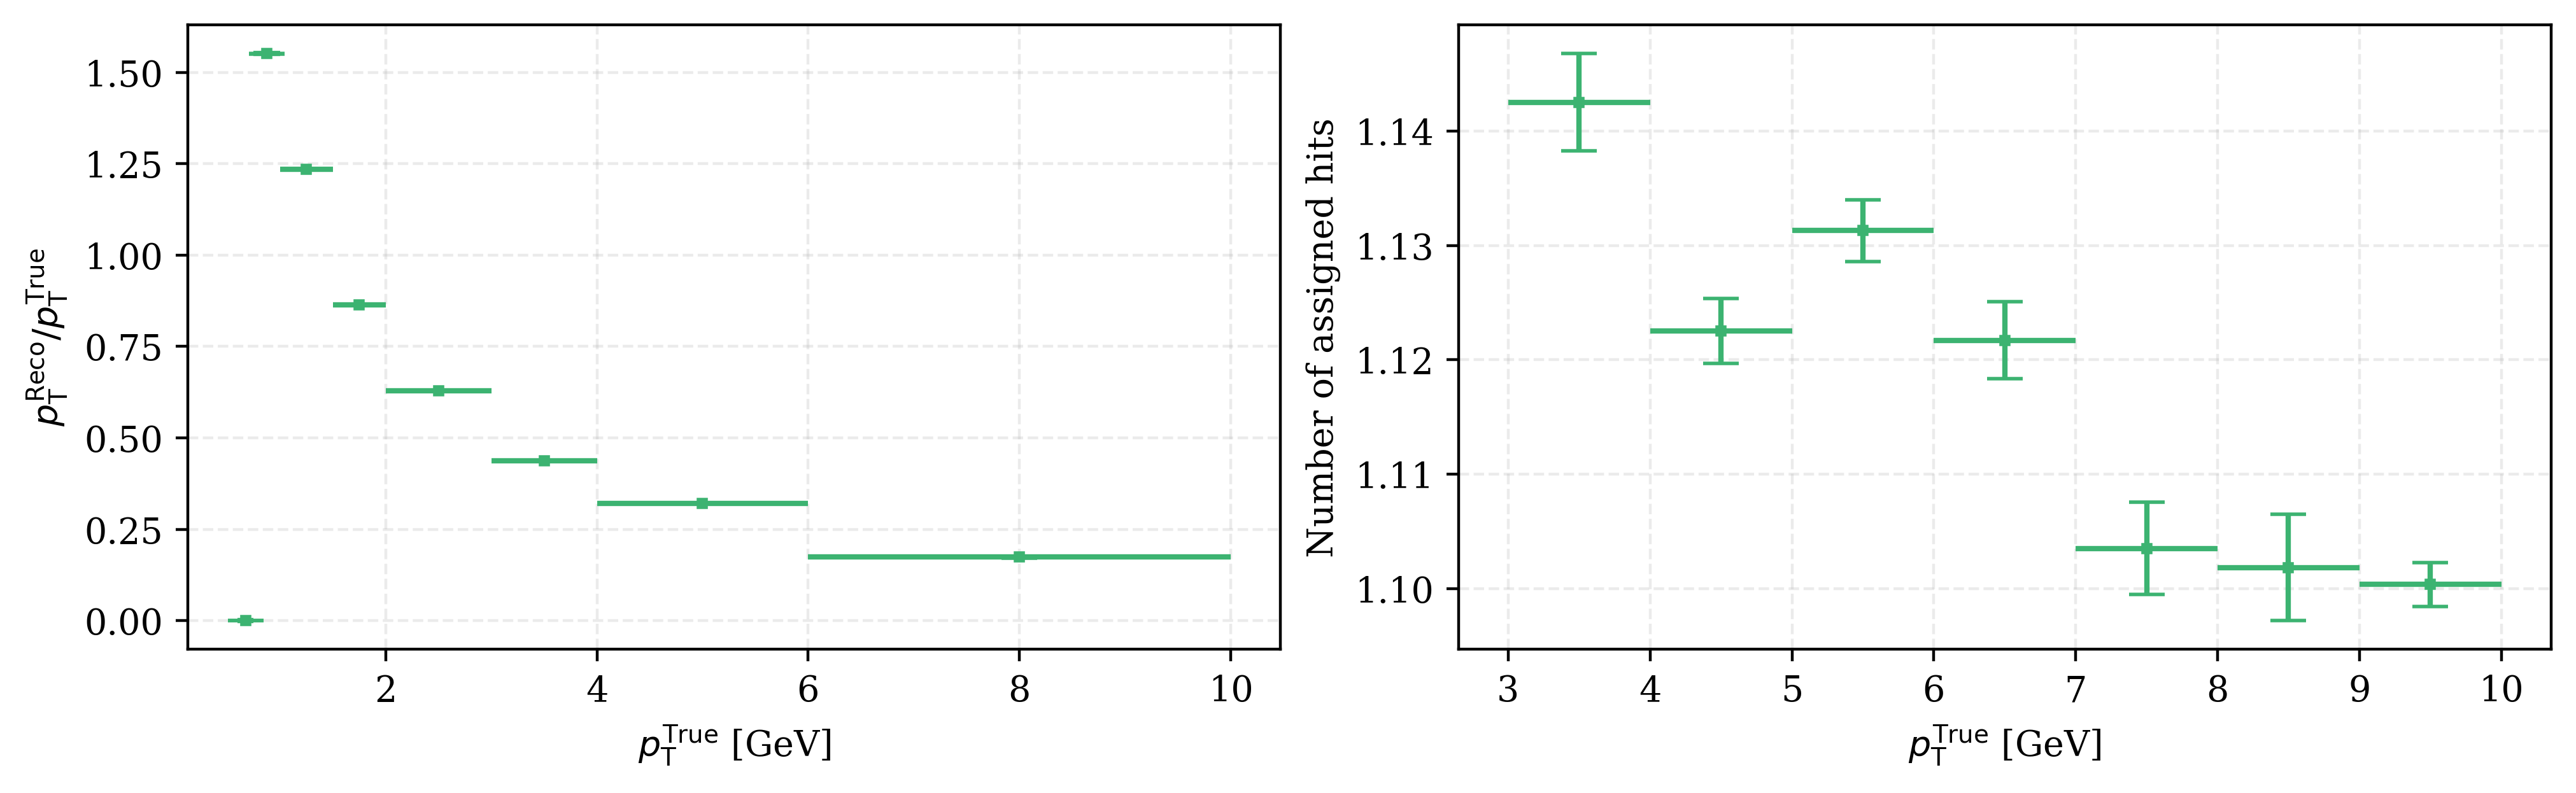

In [16]:
# make plots for the pt response vs the pt of the particle, and also vs the number of hits on the track
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
fig.set_size_inches(10, 3)
qty = "pt"
for name, (tracks, parts) in tracking_results.items():
    colour = training_colours[name]
    
    parts_eff_qty = parts["particle_"+qty][tracks["eff_dm"]]
    tracks_eff_qty = tracks["track_"+qty][tracks["eff_dm"]]
    n_assigned = tracks["n_pred_hits"][tracks["eff_dm"]]
    response = tracks_eff_qty / parts_eff_qty
    # response = np.clip(response, 0.5, 1.5)

    label = name

    # make hist
    bins = qty_bins[qty]
    b = (bins[:-1] + bins[1:]) / 2
    b_err = (bins[1:] - bins[:-1]) / 2
    
    ys, ys_err = binned(response, parts_eff_qty, bins, underflow=True, overflow=True, binomial=False)
     
    ax[0].grid(zorder=0, alpha=0.25, linestyle="--")
    ax[0].errorbar(b, ys, yerr=None, xerr=b_err, color=colour, fmt=".", label=label, marker="s", markersize=2.0)
    ax[0].errorbar(b, ys, yerr=ys_err, xerr=None, color=colour, fmt=".", marker="none", capsize=5.0, markeredgewidth=1.0)
    ax[0].set_xlabel(rf"${qty_symbols[qty]}^\mathrm{{True}}$ {qty_units[qty]}")
    ax[0].set_ylabel(rf"${qty_symbols[qty]}^\mathrm{{Reco}}/{qty_symbols[qty]}^\mathrm{{True}}$")

    bins = np.linspace(3, 10, 8)
    b = (bins[:-1] + bins[1:]) / 2
    b_err = (bins[1:] - bins[:-1]) / 2
    ys, ys_err = binned(response, n_assigned, bins, binomial=False)
    ax[1].grid(zorder=0, alpha=0.25, linestyle="--")
    ax[1].errorbar(b, ys, yerr=None, xerr=b_err, color=colour, fmt=".", label=label, marker="s", markersize=2.0)
    ax[1].errorbar(b, ys, yerr=ys_err, xerr=None, color=colour, fmt=".", marker="none", capsize=5.0, markeredgewidth=1.0)
    ax[1].set_xlabel(rf"${qty_symbols[qty]}^\mathrm{{True}}$ {qty_units[qty]}")
    ax[1].set_ylabel(rf"Number of assigned hits")

fig.show()

In [17]:
# ----------------------------------------------------
# Efficiency and fake rate numbers
# ----------------------------------------------------
for name, (tracks, parts) in tracking_results.items():
    print(training)
    tgts = parts[parts.reconstructable]

    # compute high pt integrated metrics
    high_pt_parts = tgts[tgts.pt > 1.0]
    high_pt_parts_900 = tgts[tgts.pt > 0.9]
    high_pt_eff = high_pt_parts.eff_dm.mean()
    high_pt_eff_900 = high_pt_parts_900.eff_dm.mean()
    high_pt_tracks = tracks[tracks.matched_pt > 1.0]
    high_pt_tracks_900 = tracks[tracks.matched_pt > 0.9]
    high_pt_fr = 1 - (high_pt_tracks.eff_dm & ~tracks.duplicate).mean()
    high_pt_fr_900 = 1 - (high_pt_tracks_900.eff_dm & ~tracks.duplicate).mean()

    # compute the overall fake rate
    integrated_fr = (~tracks.eff_dm & ~tracks.duplicate).mean()

    # print summary
    print(f"N events: {100}, N particles: {len(parts)}, N tracks: {len(tracks)}")
    print(f"DM Integrated efficiency: {tgts.eff_dm.mean():.1%}")
    print(f"DM Efficiency for pT > 1.0 GeV: {high_pt_eff:.1%}")
    print(f"DM Efficiency for pT > 0.9 GeV: {high_pt_eff_900:.1%}")
    print()
    print(f"DM Integrated fake rate: {integrated_fr:.1%}")
    print(f"DM Fake rate for pT > 1.0 GeV: {high_pt_fr:.1%}")
    print(f"DM Fake rate for pT > 0.9 GeV: {high_pt_fr_900:.1%}")
    print()
    print(f"Perfect integrated Efficiency: {tgts.eff_perfect.mean():.1%}")
    print(f"Perfect Efficiency for pT > 1.0 GeV: {high_pt_parts.eff_perfect.mean():.1%}")
    print(f"Perfect Efficiency for pT > 0.9 GeV: {high_pt_parts_900.eff_perfect.mean():.1%}")
    print()
    print(f"Duplicate rate: {tracks.duplicate.mean():.1%}")
    print("\n")

NameError: name 'training' is not defined

In [18]:
# ----------------------------------------------------
# Efficiency and fake rate numbers
# ----------------------------------------------------
for name, (tracks, parts) in tracking_results.items():
    print(name)
    tgts = parts[parts.reconstructable]

    # compute high pt integrated metrics
    high_pt_parts = tgts[tgts.particle_pt > 1.0]
    high_pt_parts_900 = tgts[tgts.particle_pt > 0.9]
    high_pt_eff = high_pt_parts.eff_dm.mean()
    high_pt_eff_900 = high_pt_parts_900.eff_dm.mean()
    high_pt_tracks = tracks[tracks.track_pt > 1.0]
    high_pt_tracks_900 = tracks[tracks.track_pt > 0.9]
    high_pt_fr = 1 - (high_pt_tracks.eff_dm & ~tracks.duplicate).mean()
    high_pt_fr_900 = 1 - (high_pt_tracks_900.eff_dm & ~tracks.duplicate).mean()

    # compute the overall fake rate
    integrated_fr = (~tracks.eff_dm & ~tracks.duplicate).mean()

    # print summary
    print(f"N events: {100}, N particles: {len(parts)}, N tracks: {len(tracks)}")
    print(f"DM Integrated efficiency: {tgts.eff_dm.mean():.1%}")
    print(f"DM Efficiency for pT > 1.0 GeV: {high_pt_eff:.1%}")
    print(f"DM Efficiency for pT > 0.9 GeV: {high_pt_eff_900:.1%}")
    print()
    print(f"DM Integrated fake rate: {integrated_fr:.1%}")
    print(f"DM Fake rate for pT > 1.0 GeV: {high_pt_fr:.1%}")
    print(f"DM Fake rate for pT > 0.9 GeV: {high_pt_fr_900:.1%}")
    print()
    print(f"Perfect integrated Efficiency: {tgts.eff_perfect.mean():.1%}")
    print(f"Perfect Efficiency for pT > 1.0 GeV: {high_pt_parts.eff_perfect.mean():.1%}")
    print(f"Perfect Efficiency for pT > 0.9 GeV: {high_pt_parts_900.eff_perfect.mean():.1%}")
    print()
    print(f"Duplicate rate: {tracks.duplicate.mean():.1%}")
    print("\n")

0.9 GeV
N events: 100, N particles: 220000, N tracks: 220000
DM Integrated efficiency: 70.9%
DM Efficiency for pT > 1.0 GeV: 70.6%
DM Efficiency for pT > 0.9 GeV: 70.9%

DM Integrated fake rate: 57.1%
DM Fake rate for pT > 1.0 GeV: 56.2%
DM Fake rate for pT > 0.9 GeV: 56.4%

Perfect integrated Efficiency: 33.9%
Perfect Efficiency for pT > 1.0 GeV: 33.8%
Perfect Efficiency for pT > 0.9 GeV: 33.9%

Duplicate rate: 0.0%


